In [1]:
import pandas as pd
import numpy as np

In [2]:
%load_ext autoreload

In [3]:
orders_filenames = [
    'LUNA_FullChannel_GDAX_20220511_17hr.json',
    'LUNA_FullChannel_GDAX_20220511_18hr.json',
    'LUNA_FullChannel_GDAX_20220511_19hr.json',
    'LUNA_FullChannel_GDAX_20220511_20hr.json',
]

tickers_filenames = [
    'LUNA_Ticker_GDAX_20220511_17hr.json',
    'LUNA_Ticker_GDAX_20220511_18hr.json',
    'LUNA_Ticker_GDAX_20220511_19hr.json',
    'LUNA_Ticker_GDAX_20220511_20hr.json',
]

In [4]:
# orders_df = pd.read_json(f'../../luna_crash_dataset/luna/{orders_filenames[0]}', lines=True)

# for filename in orders_filenames[1:]:
#     tmp_df = pd.read_json(f'../../luna_crash_dataset/luna/{filename}', lines=True)
#     orders_df = pd.concat([orders_df, tmp_df])

In [5]:
ticker_df = pd.read_json(f'../../luna_crash_dataset/luna/{tickers_filenames[0]}', lines=True)

for filename in tickers_filenames[1:]:
    tmp_df = pd.read_json(f'../../luna_crash_dataset/luna/{filename}', lines=True)
    ticker_df = pd.concat([ticker_df, tmp_df])

## 1. Preprocessing

### 1.1 Add timestamp

In [6]:
# orders_df.time = pd.to_datetime(orders_df.time)
# orders_df['timestamp'] = orders_df['time'].astype('int64')

ticker_df.time = pd.to_datetime(ticker_df.time)
ticker_df['timestamp'] = ticker_df['time'].astype('int64')

### 1.2 Set ticker interval borders

In [7]:
ticker_df.sort_values(by='sequence', inplace=True)
ticker_df['sequence_start'] = ticker_df['sequence']
ticker_df['sequence_end'] = ticker_df['sequence'].shift(-1)
ticker_df.dropna(subset=['sequence_end'], inplace=True)
ticker_df.sequence_end = ticker_df.sequence_end.astype(int)

### 1.3 Add middle price

In [8]:
ticker_df['mid_price'] = (ticker_df['best_bid'] + ticker_df['best_ask']) / 2

### 1.4 Add column mapping ticker to orders

In [9]:
def find_matching_range(sequence):
    mask = (ticker_df.sequence_start <= sequence) & (sequence < ticker_df.sequence_end)
    if mask.any():
        return ticker_df[mask].sequence.iloc[0]


# orders_df['ticker_sequence'] = orders_df.sequence.apply(find_matching_range)
# orders_df.to_csv('full_channel_df_with_ticker_sequence.csv', index=False)
# orders_df = pd.read_csv('full_channel_df_with_ticker_sequence.csv')
# orders_df.time = pd.to_datetime(orders_df.time)
# orders_df.drop(orders_df[orders_df.price == ''].index, inplace=True)
# orders_df.price = orders_df.price.astype(float)
# orders_df.dropna(subset=['ticker_sequence'], inplace=True)
# orders_df = orders_df.merge(ticker_df.drop(columns=['price', 'timestamp', 'side', 'time', 'type', 'trade_id']), left_on='ticker_sequence', right_on='sequence', how='inner')
# orders_df.to_csv('orders_df_with_ticker.csv', index=False)
orders_df = pd.read_csv('orders_df_with_ticker.csv')
orders_df.time = pd.to_datetime(orders_df.time)

### 1.5 Add active/passive area fields

In [10]:
alpha = 0.5

passive_bid_area = orders_df.price.between(orders_df.best_bid - 2 * alpha, orders_df.best_bid - alpha)
passive_ask_area = orders_df.price.between(orders_df.best_ask + alpha, orders_df.best_ask + 2 * alpha)
passive_area_mask = passive_bid_area | passive_ask_area

active_area_mask = orders_df.price.between(orders_df.best_bid - alpha, orders_df.best_ask + alpha)

In [11]:
orders_df['active_area'] = active_area_mask
orders_df['passive_area'] = passive_area_mask

In [12]:
orders_df[orders_df.active_area].shape

(2267121, 38)

In [13]:
(orders_df.trade_id_x == orders_df.trade_id_y).sum()

np.int64(137939)

### 1.6 Get cancelled orders

In [14]:
passive_area_orders = orders_df[orders_df['passive_area']]
passive_area_orders.shape

(44212, 38)

In [15]:
active_area_orders = orders_df[orders_df['active_area']]
active_area_orders.shape

(2267121, 38)

In [18]:
def prepare_dataset(orders_df):
    aggregated_orders = (
        orders_df[['order_id', 'reason', 'size', 'order_type', 'type', 'time', 'price', 'mid_price', 'best_bid', 'best_ask', 'side']]
        .groupby('order_id')
        .agg({'order_type': list, 'type': list, 'reason': list, 'size': list, 'time': list, 'price': list, 'mid_price': list, 'best_bid': list, 'best_ask': list, 'side': list})
    )
    aggregated_orders['time_received'] = aggregated_orders.time.apply(lambda x: x[0])
    aggregated_orders['price_received'] = aggregated_orders.price.apply(lambda x: x[0])
    aggregated_orders['mid_price_received'] = aggregated_orders.mid_price.apply(lambda x: x[0])
    aggregated_orders['mid_price_cancelled'] = aggregated_orders.mid_price.apply(lambda x: x[-1])
    aggregated_orders['mid_price_change'] = np.abs(aggregated_orders.mid_price_cancelled - aggregated_orders.mid_price_received) / aggregated_orders.mid_price_received
    aggregated_orders['bid_price_received'] = aggregated_orders.best_bid.apply(lambda x: x[0])
    aggregated_orders['bid_price_cancelled'] = aggregated_orders.best_bid.apply(lambda x: x[-1])
    aggregated_orders['bid_price_change'] = np.abs(aggregated_orders.bid_price_received - aggregated_orders.bid_price_cancelled) / aggregated_orders.bid_price_received
    aggregated_orders['ask_price_received'] = aggregated_orders.best_ask.apply(lambda x: x[0])
    aggregated_orders['ask_price_cancelled'] = aggregated_orders.best_ask.apply(lambda x: x[-1])
    aggregated_orders['ask_price_change'] = np.abs(aggregated_orders.ask_price_received - aggregated_orders.ask_price_cancelled) / aggregated_orders.ask_price_received
    aggregated_orders['spread_received'] = aggregated_orders.ask_price_received - aggregated_orders.bid_price_received
    aggregated_orders['spread_cancelled'] = aggregated_orders.ask_price_cancelled - aggregated_orders.bid_price_cancelled
    aggregated_orders['spread_change'] = aggregated_orders.spread_cancelled - aggregated_orders.spread_received
    aggregated_orders['order_size'] = aggregated_orders['size'].apply(lambda x: x[0])
    aggregated_orders['side'] = aggregated_orders['side'].apply(lambda x: x[0])

    cancelled_orders = aggregated_orders[aggregated_orders['reason'].apply(lambda x: 'canceled' in x)].copy()
    cancelled_orders['time_cancelled'] = aggregated_orders.time.apply(lambda x: x[-1])

    cancelled_without_modifying = aggregated_orders[aggregated_orders['reason'].apply(lambda x: 'canceled' in x and len(x) == 3)].copy()
    cancelled_without_modifying['time_cancelled'] = aggregated_orders.time.apply(lambda x: x[-1])
    return aggregated_orders, cancelled_orders, cancelled_without_modifying

In [17]:
passive_aggregated_orders, passive_cancelled_orders, passive_cancelled_without_modifying = prepare_dataset(orders_df[orders_df['passive_area']])
active_aggregated_orders, active_cancelled_orders, active_cancelled_without_modifying = prepare_dataset(orders_df[orders_df['active_area']])
full_aggregated_orders, full_cancelled_orders, full_cancelled_without_modifying = prepare_dataset(orders_df)

In [19]:
from datetime import timedelta


def add_features_and_targets(orders_df):
    orders_df.loc[:, 'order_size'] = orders_df['size'].apply(lambda x: x[0])
    orders_df.loc[:, 'duration'] = orders_df.time.apply(lambda x: x[2] - x[0])
    orders_df.loc[:, 'duration_sec'] = orders_df.duration.apply(lambda x: x.total_seconds())
    orders_df.loc[:, '10_min'] = orders_df.duration < timedelta(minutes=10)
    orders_df.loc[:, '1_min'] = orders_df.duration < timedelta(minutes=1)
    orders_df.loc[:, '30_sec'] = orders_df.duration < timedelta(seconds=30)
    orders_df.loc[:, '10_sec'] = orders_df.duration < timedelta(seconds=10)
    orders_df.loc[:, '5_sec'] = orders_df.duration < timedelta(seconds=5)
    orders_df.loc[:, '3_sec'] = orders_df.duration < timedelta(seconds=3)
    orders_df.loc[:, '2_sec'] = orders_df.duration < timedelta(seconds=2)
    orders_df.loc[:, '1_sec'] = orders_df.duration < timedelta(seconds=1)
    return orders_df

In [ ]:
full_cancelled_without_modifying.time

In [20]:
full_cancelled_without_modifying = add_features_and_targets(full_cancelled_without_modifying)
active_cancelled_without_modifying = add_features_and_targets(active_cancelled_without_modifying)
passive_cancelled_without_modifying = add_features_and_targets(passive_cancelled_without_modifying)

In [ ]:
sample = passive_cancelled_without_modifying[passive_cancelled_without_modifying['10_min'] & (passive_cancelled_without_modifying.order_size > 1000)]
sample[['order_size', 'duration_sec']].describe()

In [16]:
from matplotlib import pyplot as plt


def plot_price_received_vs_time(orders_df, sample, order_sizes: list[int]):
    num_rows = (len(order_sizes) + 1) // 2
    fig, axis = plt.subplots(num_rows, 2, figsize=(16, 6 * num_rows))
    axis = axis.flatten()
    price_sample = orders_df.iloc[::100]

    y_min, y_max = sample.price_received.min(), sample.price_received.max()
    for i, order_size in enumerate(order_sizes):
        sample = sample[sample.order_size > order_size]
        buy_orders = sample[sample.side == 'buy']
        sell_orders = sample[sample.side == 'sell']
        
        axis[i].scatter(buy_orders.time_received, buy_orders.price_received, alpha=0.2, color='green')
        axis[i].scatter(sell_orders.time_received, sell_orders.price_received, alpha=0.2, color='red')
        axis[i].scatter(price_sample.time, price_sample.mid_price, alpha=1, s=0.1, color='blue')
        axis[i].set_xlabel('Time Received')
        axis[i].set_ylabel('Price Received')
        axis[i].set_title(f'Price Received vs Time for Canceled Orders (Size > {order_size})')
        axis[i].set_ylim(y_min, y_max)
    
    for i in range(len(order_sizes), len(axis)):
        axis[i].set_visible(False)

In [17]:
orders_df.iloc[213][['type', 'order_type', 'order_id', 'taker_order_id', 'maker_order_id', 'price', 'best_bid', 'best_ask', 'side', 'size', 'remaining_size']]

type                                              done
order_type                                         NaN
order_id          f649198f-6aff-4d2b-86eb-b1241c19dd37
taker_order_id                                     NaN
maker_order_id                                     NaN
price                                             2.42
best_bid                                          2.42
best_ask                                          2.44
side                                               buy
size                                               NaN
remaining_size                                     0.0
Name: 213, dtype: object

In [18]:
orders_df[orders_df.taker_order_id == 'f955c1fa-f023-42c2-ad51-214b0c5f9da4'][['type', 'order_type', 'order_id', 'maker_order_id', 'taker_order_id', 'price', 'best_bid', 'best_ask', 'side', 'size', 'remaining_size']]

,type,order_type,order_id,maker_order_id,taker_order_id,price,best_bid,best_ask,side,size,remaining_size
212,match,NaN,NaN,f649198f-6aff-4d2b-86eb-b1241c19dd37,f955c1fa-f023-42c2-ad51-214b0c5f9da4,2.42,2.42,2.44,buy,1265.088,NaN
214,match,NaN,NaN,e413fa6a-0b2e-4ec1-825e-9e43588a0b40,f955c1fa-f023-42c2-ad51-214b0c5f9da4,2.42,2.41,2.44,buy,14.000,NaN
216,match,NaN,NaN,841774b8-15de-418b-8437-5f1cc2109ae0,f955c1fa-f023-42c2-ad51-214b0c5f9da4,2.41,2.41,2.44,buy,121.578,NaN
218,match,NaN,NaN,7f12d15f-608f-40ca-8ae7-3d416f0eb7ff,f955c1fa-f023-42c2-ad51-214b0c5f9da4,2.41,2.40,2.44,buy,235.104,NaN
220,match,NaN,NaN,ee8560f1-f822-40ae-967c-13c90fd47a67,f955c1fa-f023-42c2-ad51-214b0c5f9da4,2.40,2.40,2.44,buy,225.783,NaN
222,match,NaN,NaN,58e5969c-50a7-46a8-a352-c87d2ec47cd9,f955c1fa-f023-42c2-ad51-214b0c5f9da4,2.40,2.39,2.44,buy,596.488,NaN


In [19]:
orders_df[orders_df.maker_order_id == 'f955c1fa-f023-42c2-ad51-214b0c5f9da4'][['type', 'order_type', 'order_id', 'maker_order_id', 'taker_order_id', 'price', 'best_bid', 'best_ask', 'side', 'size', 'remaining_size']]

,type,order_type,order_id,maker_order_id,taker_order_id,price,best_bid,best_ask,side,size,remaining_size
238,match,NaN,NaN,f955c1fa-f023-42c2-ad51-214b0c5f9da4,cfc638a3-d87c-4d2a-9d0c-95ea75ebd5fd,2.4,2.39,2.4,sell,10.622,NaN
279,match,NaN,NaN,f955c1fa-f023-42c2-ad51-214b0c5f9da4,2690df9a-f3f8-428e-983b-6a3cdf5b2448,2.4,2.39,2.4,sell,74.943,NaN
294,match,NaN,NaN,f955c1fa-f023-42c2-ad51-214b0c5f9da4,c85ae2e9-990b-4a17-83c1-267f8b7c9b60,2.4,2.39,2.4,sell,228.773,NaN
497,match,NaN,NaN,f955c1fa-f023-42c2-ad51-214b0c5f9da4,6064d2f2-417d-42c7-a089-b5652ce3b21c,2.4,2.39,2.4,sell,20.911,NaN
501,match,NaN,NaN,f955c1fa-f023-42c2-ad51-214b0c5f9da4,8f7cb76c-e946-4899-a1ae-ce2ee1274f7e,2.4,2.39,2.4,sell,542.371,NaN
517,match,NaN,NaN,f955c1fa-f023-42c2-ad51-214b0c5f9da4,048c6572-7254-48c9-ad40-65fb00112112,2.4,2.39,2.4,sell,1982.221,NaN
599,match,NaN,NaN,f955c1fa-f023-42c2-ad51-214b0c5f9da4,efaf002e-8dfb-42cc-9e5c-659b5cdf912d,2.4,2.39,2.4,sell,4.256,NaN
606,match,NaN,NaN,f955c1fa-f023-42c2-ad51-214b0c5f9da4,426c4b1a-4d63-444e-b127-b6b740482f86,2.4,2.39,2.4,sell,17.739,NaN
636,match,NaN,NaN,f955c1fa-f023-42c2-ad51-214b0c5f9da4,cac86f17-61d1-4c67-9420-49a91b212649,2.4,2.39,2.4,sell,28.412,NaN
726,match,NaN,NaN,f955c1fa-f023-42c2-ad51-214b0c5f9da4,74aee2c9-161e-4420-94ad-a67edf0838c8,2.4,2.39,2.4,sell,0.695,NaN


In [20]:
# orders_df[(orders_df.reason == 'canceled') & orders_df.price.isna()].iloc[0].to_dict()
# orders_df[orders_df.type == 'done'].iloc[200000]
orders_df[orders_df.order_id == 'f955c1fa-f023-42c2-ad51-214b0c5f9da4'][['type', 'order_type', 'order_id', 'price', 'best_bid', 'best_ask', 'side', 'size', 'remaining_size']]


,type,order_type,order_id,price,best_bid,best_ask,side,size,remaining_size
211,received,limit,f955c1fa-f023-42c2-ad51-214b0c5f9da4,2.4,2.42,2.44,sell,13258.124,NaN
224,open,NaN,f955c1fa-f023-42c2-ad51-214b0c5f9da4,2.4,2.39,2.44,sell,NaN,10800.083
1138,done,NaN,f955c1fa-f023-42c2-ad51-214b0c5f9da4,2.4,2.37,2.40,sell,NaN,7054.013


In [21]:
orders_df[(orders_df.type == 'open') & (orders_df.side == 'sell') & (orders_df.price < orders_df.best_bid)]

,order_id,order_type,size,price,client_oid,type,side,product_id_x,time,sequence_x,...,volume_30d,best_bid,best_ask,trade_id_y,last_size,sequence_start,sequence_end,mid_price,active_area,passive_area
13883,67f20933-0b80-4e61-8136-2530edd79d99,NaN,NaN,2.37,NaN,open,sell,WLUNA-USD,2022-05-11 16:00:59.342304+00:00,1292628310,...,5.212762e+07,2.38,2.41,7885573,2.713,1292628148,1292628364,2.395,True,False
89655,bd70f942-cc3f-4a39-8fc2-ee1d8d841c1b,NaN,NaN,2.29,NaN,open,sell,WLUNA-USD,2022-05-11 16:05:18.365770+00:00,1292704082,...,5.269019e+07,2.30,2.31,7889914,136.792,1292704074,1292704107,2.305,True,False
204374,c9d7bdd5-69c8-4873-8617-309c9966f917,NaN,NaN,2.24,NaN,open,sell,WLUNA-USD,2022-05-11 16:12:33.509906+00:00,1292818801,...,5.313392e+07,2.25,2.27,7895253,16.135,1292818757,1292818824,2.260,True,False
204377,d710b517-0c3b-4a78-86fb-c83554d598d5,NaN,NaN,2.24,NaN,open,sell,WLUNA-USD,2022-05-11 16:12:33.522423+00:00,1292818804,...,5.313392e+07,2.25,2.27,7895253,16.135,1292818757,1292818824,2.260,True,False
204392,b8b40ed4-8b4e-4d0f-bfa9-879a68ba5f83,NaN,NaN,2.24,NaN,open,sell,WLUNA-USD,2022-05-11 16:12:33.615813+00:00,1292818819,...,5.313392e+07,2.25,2.27,7895253,16.135,1292818757,1292818824,2.260,True,False
323612,519ae2e9-6e51-4321-aa5b-56a041e1a61d,NaN,NaN,2.37,NaN,open,sell,WLUNA-USD,2022-05-11 16:21:41.729821+00:00,1292938039,...,5.368645e+07,2.38,2.39,7900442,13.860,1292937977,1292938126,2.385,True,False
415809,434c65ee-d4c3-49a5-9c2b-ef8520aa9fc5,NaN,NaN,2.37,NaN,open,sell,WLUNA-USD,2022-05-11 16:28:28.244770+00:00,1293030236,...,5.456456e+07,2.38,2.39,7904718,13.433,1293030135,1293030299,2.385,True,False
415866,26153a2a-493e-4355-b5e3-127e63815f18,NaN,NaN,2.37,NaN,open,sell,WLUNA-USD,2022-05-11 16:28:28.306937+00:00,1293030293,...,5.456456e+07,2.38,2.39,7904718,13.433,1293030135,1293030299,2.385,True,False
572053,74ce950f-7d97-442f-a5a3-9fc9e78c2320,NaN,NaN,2.49,NaN,open,sell,WLUNA-USD,2022-05-11 16:42:29.767455+00:00,1293186480,...,5.611504e+07,2.50,2.52,7912889,13.999,1293186418,1293186524,2.510,True,False
576616,2be65f5f-ebbd-42ac-b10d-285eb05de352,NaN,NaN,2.52,NaN,open,sell,WLUNA-USD,2022-05-11 16:42:45.588308+00:00,1293191043,...,5.613496e+07,2.53,2.54,7913095,20.000,1293191030,1293191105,2.535,True,False


In [22]:
orders_df[(orders_df.reason == 'filled') & (orders_df.price.isna())][['type', 'order_type', 'order_id', 'price', 'best_bid', 'best_ask', 'side', 'size', 'remaining_size']]['remaining_size'].unique()

array([    nan,   0.   , 106.235,   3.995, 119.36 ,   0.246])

In [429]:
from collections import defaultdict

def model_order_book(orders_df, output_start: int | None = None):
    buy_order_book = defaultdict(int)
    sell_order_book = defaultdict(int)
    received_orders = set()
    opened_orders = set()
    _min = None
    _max = None
    output_start = orders_df.index[-1] + 1 if output_start is None else output_start
    
    for i, (idx, row) in enumerate(orders_df.iterrows()):
        if i % 1000 == 0:
            print(f'{i} / {len(orders_df)}')
        _type, order_type, reason, order_id, maker_order_id, taker_order_id, price, size, remaining_size, old_size, new_size, side, best_bid, best_ask = row['type'], row['order_type'], row['reason'], row['order_id'], row['maker_order_id'], row['taker_order_id'], row['price'], row['size'], row['remaining_size'], row['old_size'], row['new_size'], row['side'], row['best_bid'], row['best_ask']
        if i > output_start:
            print(idx)
            print(order_id)
        if order_type == 'market':
            received_orders.add(order_id)
            continue
        if _type == 'received':
            received_orders.add(order_id)
        elif _type == 'open':
            assert ~np.isnan(price)
            assert ~np.isnan(remaining_size)
            opened_orders.add(order_id)
            if side == 'buy':
                if _min is not None and price >= _min:
                    raise ValueError(f"Price {price} is greater than or equal to _min {_min}. {idx}")
                buy_order_book[price] += remaining_size
            elif side == 'sell':
                if _max is not None and price <= _max:
                    raise ValueError(f"Price {price} is less than or equal to _max {_max}. {idx}")
                sell_order_book[price] += remaining_size
            else:
                raise ValueError(f"Invalid side: {side}")
        elif _type == 'match':
            if maker_order_id not in received_orders:
                if i > output_start:
                    print(f'maker_order_id {maker_order_id} not in received_orders. skip')
                continue
            if taker_order_id not in received_orders:
                if i > output_start:
                    print(f'taker_order_id {taker_order_id} not in received_orders. skip')
                continue
            assert ~np.isnan(price)
            assert ~np.isnan(size)
            if side == 'buy':
                buy_order_book[price] -= size
                if np.isclose(buy_order_book[price], 0):
                    del buy_order_book[price]
            elif side == 'sell':
                sell_order_book[price] -= size
                if np.isclose(sell_order_book[price], 0):
                    del sell_order_book[price]
            else:
                raise ValueError(f"Invalid side: {side}")
        elif _type == 'change':
            if order_id not in received_orders:
                if i > output_start:
                    print(f'order_id {order_id} not in received_orders. skip')
                continue
            if order_id not in opened_orders:
                if i > output_start:
                    print(f'order_id {order_id} not in opened_orders. skip')
                continue
            assert ~np.isnan(new_size)
            assert ~np.isnan(old_size)
            diff = new_size - old_size
            if side == 'buy':
                buy_order_book[price] += diff
                if np.isclose(buy_order_book[price], 0):
                    del buy_order_book[price]
            elif side == 'sell':
                sell_order_book[price] += diff
                if np.isclose(sell_order_book[price], 0):
                    del sell_order_book[price]
            else:
                raise ValueError(f"Invalid side: {side}")
        elif reason == 'canceled' or _type == 'done':
            if order_id not in received_orders:
                if i > output_start:
                    print('skip. Order not in received')
                continue
            received_orders.remove(order_id)
            if order_id not in opened_orders:
                if i > output_start:
                    print('skip. Order not in opened')
                continue
            opened_orders.remove(order_id)
            if np.isnan(price) or np.isnan(remaining_size):
                continue
            if side == 'buy':
                buy_order_book[price] -= remaining_size
                if np.isclose(buy_order_book[price], 0):
                    del buy_order_book[price]
            elif side == 'sell':
                sell_order_book[price] -= remaining_size
                if np.isclose(sell_order_book[price], 0):
                    del sell_order_book[price]
            else:
                raise ValueError(f"Invalid side: {side}")
        _min = min(sell_order_book.keys()) if sell_order_book else None
        _max = max(buy_order_book.keys()) if buy_order_book else None
        if i > output_start:
            print('buy_order_book', buy_order_book)
            print('sell_order_book', sell_order_book)
    return buy_order_book, sell_order_book, best_bid, best_ask

In [442]:
from matplotlib import pyplot as plt

def draw_order_book(buy_df, sell_df, best_bid, best_ask):   
    # Create a single figure
    fig, ax = plt.subplots(figsize=(12, 6))

    # Plot buy order book
    ax.hist(buy_df['price'], weights=buy_df['volume'], bins=50, alpha=0.5, label='Buy Orders')

    ax.hist(sell_df['price'], weights=sell_df['volume'], bins=50, alpha=0.5, label='Sell Orders')

    # Add vertical lines for best bid and ask
    ax.axvline(x=best_bid, color='g', linestyle='--', label='Best Bid')
    ax.axvline(x=best_ask, color='r', linestyle='--', label='Best Ask')

    ax.set_xlabel('Price')
    ax.set_ylabel('Volume')
    ax.set_title('Order Book Volume Distribution')
    ax.legend()

    plt.tight_layout()
    plt.show()

In [431]:
list_orders = [
    'f955c1fa-f023-42c2-ad51-214b0c5f9da4',
    'f649198f-6aff-4d2b-86eb-b1241c19dd37',
    'e413fa6a-0b2e-4ec1-825e-9e43588a0b40',
    '841774b8-15de-418b-8437-5f1cc2109ae0',
    '7f12d15f-608f-40ca-8ae7-3d416f0eb7ff',
    'ee8560f1-f822-40ae-967c-13c90fd47a67',
    '58e5969c-50a7-46a8-a352-c87d2ec47cd9',
    'cfc638a3-d87c-4d2a-9d0c-95ea75ebd5fd',
    '2690df9a-f3f8-428e-983b-6a3cdf5b2448',
    'c85ae2e9-990b-4a17-83c1-267f8b7c9b60',
    '6064d2f2-417d-42c7-a089-b5652ce3b21c',
    '8f7cb76c-e946-4899-a1ae-ce2ee1274f7e',
    '048c6572-7254-48c9-ad40-65fb00112112',
    'efaf002e-8dfb-42cc-9e5c-659b5cdf912d',
    '426c4b1a-4d63-444e-b127-b6b740482f86',
    'cac86f17-61d1-4c67-9420-49a91b212649',
    '74aee2c9-161e-4420-94ad-a67edf0838c8',
    'fbde117c-6bbb-4d92-96fb-2501a3e2b236',
    '2ec460fe-cd36-4325-91ed-7c1e7a951398',
    '86e9672a-8b20-4501-a583-78012036605a',
    'c686fe3b-b7e1-4049-8eff-abfa04af3c68',
    'a167e998-4374-4270-a5df-baeb6a540cc8',
]

In [432]:
test_df = orders_df[(orders_df.order_id.isin(list_orders)) | (orders_df.maker_order_id.isin(list_orders)) | (orders_df.taker_order_id.isin(list_orders))]

In [433]:
test_df = orders_df.iloc[:1000000]

In [438]:
buy_order_book, sell_order_book, best_bid, best_ask = model_order_book(orders_df)

0 / 2375073
1000 / 2375073
2000 / 2375073
3000 / 2375073
4000 / 2375073
5000 / 2375073
6000 / 2375073
7000 / 2375073
8000 / 2375073
9000 / 2375073
10000 / 2375073
11000 / 2375073
12000 / 2375073
13000 / 2375073
14000 / 2375073
15000 / 2375073
16000 / 2375073
17000 / 2375073
18000 / 2375073
19000 / 2375073
20000 / 2375073
21000 / 2375073
22000 / 2375073
23000 / 2375073
24000 / 2375073
25000 / 2375073
26000 / 2375073
27000 / 2375073
28000 / 2375073
29000 / 2375073
30000 / 2375073
31000 / 2375073
32000 / 2375073
33000 / 2375073
34000 / 2375073
35000 / 2375073
36000 / 2375073
37000 / 2375073
38000 / 2375073
39000 / 2375073
40000 / 2375073
41000 / 2375073
42000 / 2375073
43000 / 2375073
44000 / 2375073
45000 / 2375073
46000 / 2375073
47000 / 2375073
48000 / 2375073
49000 / 2375073
50000 / 2375073
51000 / 2375073
52000 / 2375073
53000 / 2375073
54000 / 2375073
55000 / 2375073
56000 / 2375073
57000 / 2375073
58000 / 2375073
59000 / 2375073
60000 / 2375073
61000 / 2375073
62000 / 2375073
63000

In [439]:
# Convert order book dictionaries to DataFrames
buy_df = pd.DataFrame({
    'price': list(buy_order_book.keys()),
    'volume': list(buy_order_book.values())
})

sell_df = pd.DataFrame({
    'price': list(sell_order_book.keys()),
    'volume': list(sell_order_book.values())
})


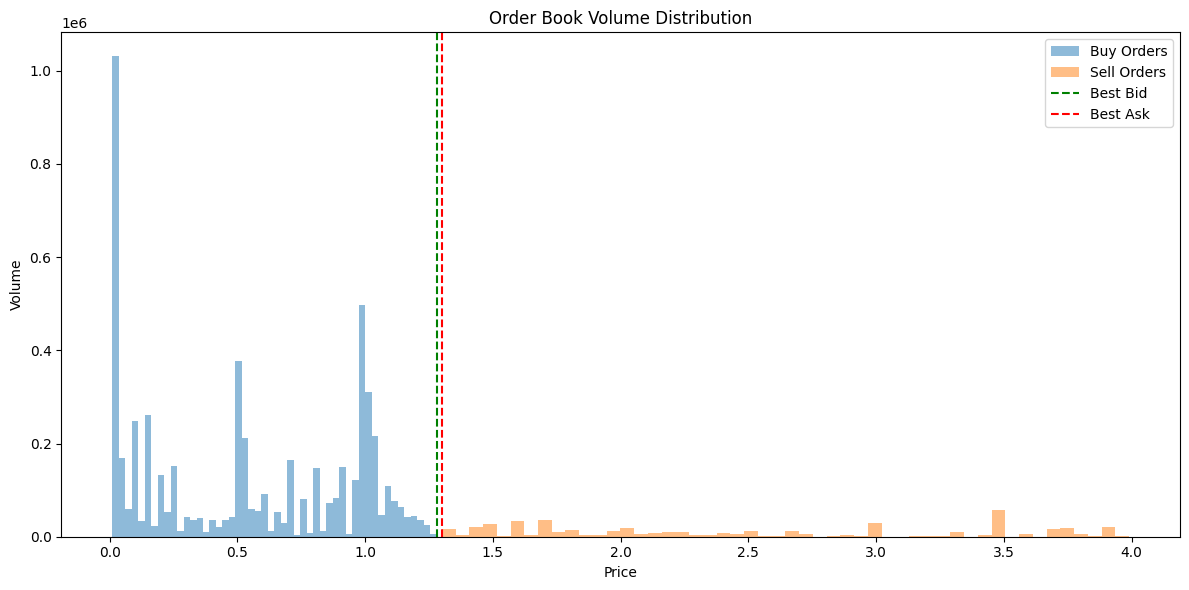

In [444]:
draw_order_book(buy_df[buy_df.volume < 2000000], sell_df[sell_df.price < 4], best_bid, best_ask)

In [241]:
plot_price_received_vs_time(orders_df, passive_cancelled_without_modifying[passive_cancelled_without_modifying['10_min'] & ~passive_cancelled_without_modifying['1_min']], [1000, 5000, 10000])

NameError: name 'plot_price_received_vs_time' is not defined

In [ ]:
from matplotlib import pyplot as plt


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.scatter(sample.duration_sec, sample.order_size, alpha=0.5)
ax1.set_xlabel('Duration (seconds)')
ax1.set_ylabel('Order Size')
ax1.set_title('Order Size vs Duration for Canceled Orders')

ax2.scatter(sample.time_received, sample.order_size, alpha=0.5)
ax2.set_xlabel('Time Received')
ax2.set_ylabel('Order Size')
ax2.set_title('Order Size vs Time Received for Canceled Orders')

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.scatter(sample.order_size, sample.price_received, alpha=0.5)
ax1.set_xlabel('Order Size')
ax1.set_ylabel('Price Received')
ax1.set_title('Order Size vs Price Received for Canceled Orders')

ax2.scatter(sample.time_received, sample.price_received, alpha=0.5)
ax2.scatter(sample.time_received, sample.bid_price_received, alpha=0.5, s=1)
ax2.scatter(sample.time_received, sample.ask_price_received, alpha=0.5, s=1)
ax2.set_xlabel('Time Received')
ax2.set_ylabel('Price Received')
ax2.set_title('Price Received vs Time Received for Canceled Orders')

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.scatter(sample.order_size, sample.mid_price_change, alpha=0.5)
ax1.set_xlabel('Order Size')
ax1.set_ylabel('Mid Price Change')
ax1.set_title('Order Size vs Mid Price Change for Canceled Orders')

ax2.scatter(sample.order_size, sample.spread_change, alpha=0.5)
ax2.set_xlabel('Order Size')
ax2.set_ylabel('Spread Change')
ax2.set_title('Order Size vs Spread Change for Canceled Orders')

In [ ]:
full_aggregated_orders

In [139]:
full_merged_df = aggregated_orders.merge(cancelled_without_modifying, left_index=True, right_index=True, how='left')

In [ ]:
cancelled_without_modifying.shape